In [1]:
#Set the devices which Jax should use. 
#This must be done before importing jax
import os
# --- Control Flag ---
USE_GPU = False
# --------------------

if USE_GPU:
    # Set JAX to use the GPU. The device number (0) is for the first GPU.
    os.environ['JAX_PLATFORMS'] = 'cuda,cpu'
    # Optional: Pin JAX to a specific GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
else:
    os.environ['JAX_PLATFORMS'] = 'cpu'
    import numpyro
    numpyro.set_host_device_count(4)
    

import jax
print(f"JAX is running on: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

import finitediffx as fdx
import pandas as pd
import numpyro
from niceode.pymc_utils import make_pymc_model
import pymc as pm
from niceode.utils import (CompartmentalModel, 
                           ODEInitVals,
                           PopulationCoeffcient,
                           neg2_log_likelihood_loss,
                           ObjectiveFunctionColumn,
                           FOCE_approx_ll_loss,
                           FOCEi_approx_ll_loss,
                           FO_approx_ll_loss
                           )
from niceode.diffeqs import OneCompartmentAbsorption
import numpy as np
import joblib as jb
from niceode.jax_utils import FO_approx_neg2ll_loss_jax


/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:2025-10-03 21:58:38,267:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/jax_plugins/xla_cud

JAX is running on: cpu
JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [2]:

df =  pd.read_csv(r"/workspaces/PK-Analysis/data/CP1805/CP1805Data.csv").iloc[1:, :]
df = df.loc[~df['Conc'].isnull(), :]
df = df.loc[df['Day'] == 1.0, :]
numeric_cols = ['Time', 'Dose', 'Conc']
for c in numeric_cols:
    df[c] = df[c].astype(pd.Float64Dtype())
#df['Time'] = df['Time'].astype(pd.Float32Dtype())
df = df.loc[df['Route'].isin(['Oral', 'Dermal'])]
df = df.sort_values(by = ['Subject', 'Day', 'Time']).reset_index(drop = True)

In [3]:
from niceode.nca import NCA
df_tmp = df.loc[df['Route'] == 'Oral', :]
df_tmp['TIME'] = df_tmp['Time']
df_tmp['DV'] = df_tmp['Conc']
df_tmp['ID'] = df_tmp['Subject']
df_tmp['AMT'] = df_tmp['Dose']
df_tmp = df_tmp.copy()
nca_obj = NCA(
     subject_id_col='ID', 
    conc_col='DV',
    time_col='TIME', 
    dose_col='AMT',
    data = df_tmp
)

nca_result_df = nca_obj.estimate_all_nca_params(terminal_phase_adj_r2_thresh=0.85)
nca_result_df.describe()

/tmp/ipykernel_54048/2849437620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['TIME'] = df_tmp['Time']
/tmp/ipykernel_54048/2849437620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['DV'] = df_tmp['Conc']
/tmp/ipykernel_54048/2849437620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


,ID,window_halflife_est,window_k_est,linup_logdown_auc,linup_logdown_aumc,cl/F,mrt,vss,boot_n
count,4.000000,4.000000,4.000000,4.0,4.0,4.0,4.0,4.0,4.0
mean,112.500000,27.422969,0.073135,99378.687497,7217013.066174,0.035352,35.297942,0.535032,0.0
std,8.812869,40.127364,0.044291,95624.149926,13458724.554313,0.019017,51.823077,0.241536,0.0
min,102.000000,6.568660,0.007910,43331.43193,365170.607972,0.007795,8.427384,0.349838,0.0
25%,107.250000,7.158062,0.065652,49993.984931,502150.581553,0.030312,9.044923,0.380648,0.0
50%,113.000000,7.758558,0.089564,55855.762858,549100.381211,0.042102,9.871122,0.454657,0.0
75%,118.250000,28.023466,0.097046,105240.465424,7263962.865831,0.047143,36.12414,0.609042,0.0
max,122.000000,87.606099,0.105501,242471.792343,27404680.894301,0.049411,113.02214,0.880976,0.0


In [4]:
df_tmp = df.loc[df['Route'] == 'Dermal', :]
df_tmp['TIME'] = df_tmp['Time']
df_tmp['DV'] = df_tmp['Conc']
df_tmp['ID'] = df_tmp['Subject']
df_tmp['AMT'] = df_tmp['Dose']
df_tmp = df_tmp.copy()
nca_obj = NCA(
     subject_id_col='ID', 
    conc_col='DV',
    time_col='TIME', 
    dose_col='AMT',
    data = df_tmp
)

nca_result_df = nca_obj.estimate_all_nca_params(terminal_phase_adj_r2_thresh=0.85)
nca_result_df.describe()

/tmp/ipykernel_54048/868055702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['TIME'] = df_tmp['Time']
/tmp/ipykernel_54048/868055702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['DV'] = df_tmp['Conc']
/tmp/ipykernel_54048/868055702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,ID,window_halflife_est,window_k_est,linup_logdown_auc,linup_logdown_aumc,cl/F,mrt,vss,boot_n
count,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0,12.0,12.0
mean,111.833333,29.194380,0.063333,119811.673196,18692096.877502,0.086424,43.019473,1.411629,0.0
std,7.259268,60.046620,0.031790,172484.107911,60189475.589374,0.066433,86.772097,0.799798,0.0
min,101.000000,6.152763,0.003163,27586.276173,444072.295965,0.002814,9.756988,0.749641,0.0
25%,105.750000,8.691262,0.041358,53632.286345,691758.583478,0.053886,13.384552,0.866962,0.0
50%,113.500000,9.782199,0.070911,76406.234391,1104449.898329,0.077361,15.792574,1.046052,0.0
75%,116.500000,16.776939,0.079946,93075.372277,2041541.627145,0.104775,26.935494,1.770276,0.0
max,123.000000,219.097448,0.112632,661072.405093,209799704.330256,0.259649,317.362671,3.282708,0.0


<Axes: xlabel='Time', ylabel='Conc'>

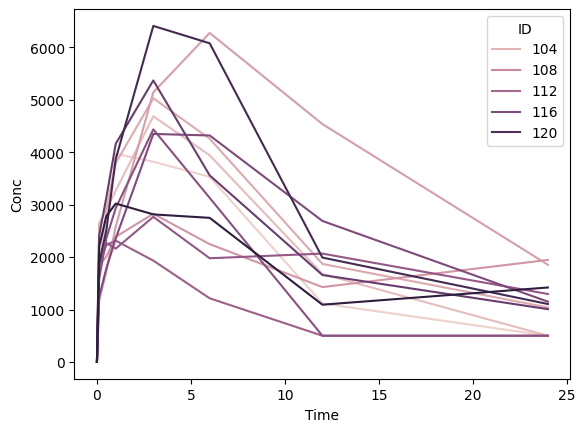

In [5]:
import seaborn as sns

sns.lineplot(df_tmp, x = 'Time', y = 'Conc', hue = 'ID')

In [6]:
me_mod_fo =  CompartmentalModel(
        model_name = "debug_cp1805_multiple_hierarchy",
            ode_t0_cols=[ ODEInitVals('Conc'), ODEInitVals('Dose'),],
            conc_at_time_col = 'Conc',
            subject_id_col = 'Subject', 
            time_col = 'Time',
            dose_col='Dose',
            ode_t0_time_val=0,
            population_coeff=[
                                PopulationCoeffcient('ka', 
                                                    optimization_init_val=(1/5), 
                                                    subject_level_intercept=True,
                                                    #optimization_lower_bound = np.log(1e-6),
                                                    #optimization_upper_bound = np.log(15),
                                                    subject_level_intercept_sd_init_val = 2, 
                                                    #subject_level_intercept_sd_upper_bound = 20,
                                                    #subject_level_intercept_sd_lower_bound=1e-6, 
                                                    aux_hierarchy_levels=True,
                                                    aux_hierarchy_names=['ka_route'], 
                                                    aux_hierarchy_init_vals=[0.0], 
                                                    aux_hierarchy_group_by_cols=['Route'], 
                                                    
                                                    
                                                    ),
                                PopulationCoeffcient('cl',
                                                    optimization_init_val = 0.08,
                                                    #optimization_lower_bound = np.log(1e-4),
                                                    #optimization_upper_bound=np.log(25),
                                                    subject_level_intercept=True, 
                                                    subject_level_intercept_sd_init_val = 2, 
                                                   # subject_level_intercept_sd_upper_bound = 5,
                                                   # subject_level_intercept_sd_lower_bound=1e-6
                                                    ),
                                PopulationCoeffcient('vd', optimization_init_val = 1,
                                                    #, optimization_lower_bound = np.log(.1)
                                                    #,optimization_upper_bound=np.log(80), 
                                                    subject_level_intercept=True, 
                                                    subject_level_intercept_sd_init_val = 2, 
                                                    #subject_level_intercept_sd_upper_bound = 5,
                                                    #subject_level_intercept_sd_lower_bound=1e-6
                                                    
                                                    #, optimization_upper_bound = np.log(.05)
                                                    ),
                            ],
            dep_vars= None, 

                                    pk_model_class=OneCompartmentAbsorption, 
                                    model_error_sigma=PopulationCoeffcient('sigma'
                                                                            ,log_transform_init_val=False
                                                                            , optimization_init_val=.5
                                                                            ,optimization_lower_bound=0.00001
                                                                            ,optimization_upper_bound=3
                                                                            ),
  
                                    batch_id='theoph_test1',

                                    significant_digits=3,
                                    #me_loss_function=FO_approx_ll_loss,
                                    jax_loss=FO_approx_neg2ll_loss_jax,
                                    use_full_omega=True, 
                                    use_surrogate_neg2ll=True, 
                                    fit_jax_objective=True,
                                    )


In [7]:
model = make_pymc_model(me_mod_fo,
                            fit_df = df,
                            link_function = 'exp',
                            use_existing_fit = False,
                            )

Successfully compiled closed stiff ODE solver
Sucessfully complied non-stiff ODE solver
Sucessfully complied augmented dynamics stiff ODE solver


2025/10/03 21:58:43 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Creating Schema with empty inputs is not allowed.


Sucessfully complied augmented dynamics stiff ODE solver
Sucessfully complied stiff ODE solver
Sucessfully complied KEYS stiff ODE solver
Sucessfully complied non-stiff PyMC ODE solver
Sucessfully complied hybrid-dimensional non-stiff PyMC ODE solver
Sucessfully complied non-dimensional non-stiff PyMC ODE solver
Sucessfully complied non-dimensional stiff PyMC ODE solver
Sucessfully complied stiff PyMC ODE solver
🏃 View run b-theoph_test1_m-debug_cp1805_multiple_hierarchy_f-e6effab0-589a-43e6-a624-b198dceeb27e at: http://mlflow-server:5000/#/experiments/377/runs/667d7d2dec344442a2679f1c101cd0e9
🧪 View experiment at: http://mlflow-server:5000/#/experiments/377
Compiling `_solve_ivp_jax_worker`


Compiling `_solve_ivp_jax_worker`


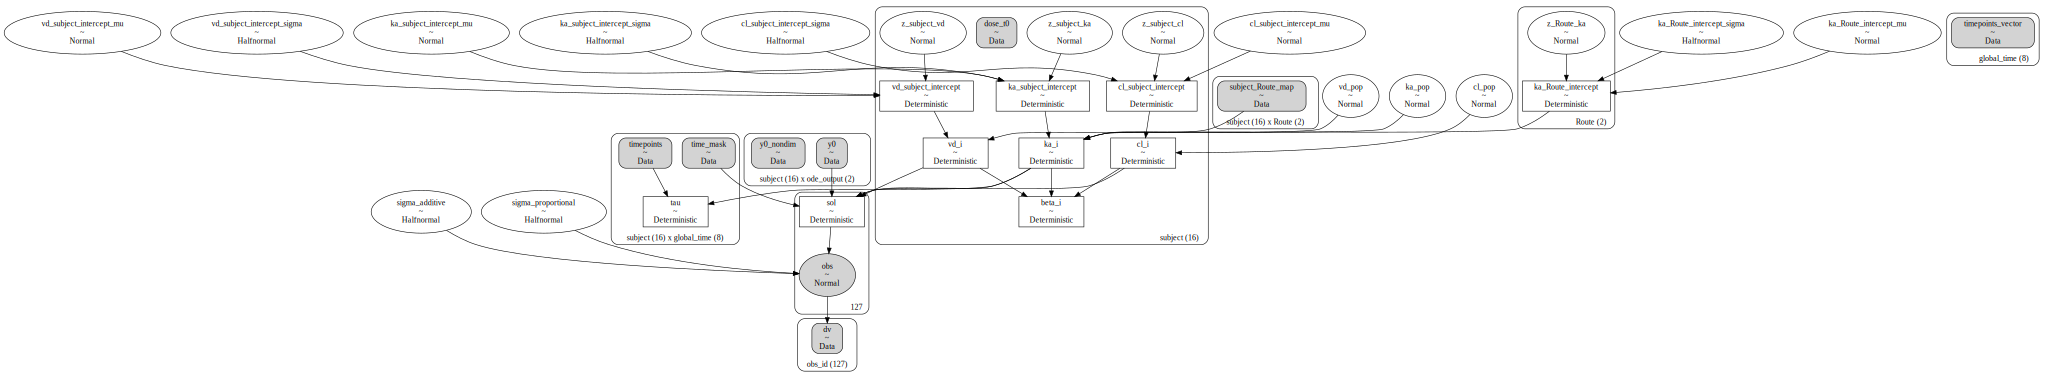

In [8]:
pm.model_to_graphviz(model)

In [9]:
chains = 4
tune = 2000
total_draws = 6000
draws = np.round(total_draws / chains, 0).astype(int)
with model:
    trace_NUTS = pm.sample(
        tune=tune,
        draws=draws,
        chains=chains,
        nuts_sampler="numpyro",
        
        target_accept=0.92, 
    )

Compiling `_solve_ivp_jax_worker`
Compiling `_solve_ivp_jax_worker`


Compiling.. :   0%|          | 0/3500 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3500 [00:05<?, ?it/s]


Running chain 0:   5%|▌         | 175/3500 [04:01<1:14:39,  1.35s/it]


Running chain 0:  10%|█         | 350/3500 [27:40<4:39:38,  5.33s/it]


Running chain 0:  15%|█▌        | 525/3500 [48:50<5:07:50,  6.21s/it]


Running chain 0:  20%|██        | 700/3500 [1:11:24<5:17:48,  6.81s/it]


Running chain 0:  25%|██▌       | 875/3500 [1:32:35<5:05:06,  6.97s/it]


Running chain 0:  30%|███       | 1050/3500 [1:52:08<4:41:02,  6.88s/it]


Running chain 0:  35%|███▌      | 1225/3500 [2:15:19<4:34:08,  7.23s/it]


Running chain 0:  40%|████      | 1400/3500 [2:39:17<4:24:05,  7.55s/it]


Running chain 0:  45%|████▌     | 1575/3500 [3:02:15<4:05:20,  7.65s/it]


Running chain 0:  50%|█████     | 1750/3500 [3:26:40<3:49:35,  7.87s/it]


Running chain 0:  55%|█████▌    | 1925/3500 [3:49:54<3:27:24,  7.90s/it]


Running chain 0:  60%|██████    | 2100/3500 [4:13:41<3:06:07,  7.9

In [1]:
import joblib as jb
dump_trace = False
trace_dump_path = r"/workspaces/PK-Analysis/data/trace_multiple_hier.jb"
if dump_trace:
    jb.dump(trace_NUTS, trace_dump_path)   

load_trace = True
if load_trace:
    trace_NUTS = jb.load(trace_dump_path)

### Inspect poorly sampled variables

In [2]:
import arviz as az
trace_summ = az.summary(trace_NUTS)

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid

In [3]:
trace_summ.loc[trace_summ['r_hat'] != 1, :]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_subject_cl[101.0],1.017,0.482,0.131,1.888,0.015,0.015,1041.0,1648.0,1.01
z_subject_cl[102.0],-0.453,0.342,-1.109,0.192,0.012,0.006,786.0,1578.0,1.01
z_subject_cl[109.0],-0.111,0.336,-0.767,0.507,0.012,0.006,732.0,1655.0,1.01
z_subject_cl[113.0],0.490,0.403,-0.215,1.295,0.012,0.008,1056.0,1855.0,1.01
z_subject_cl[117.0],-0.125,0.361,-0.780,0.572,0.012,0.007,864.0,1570.0,1.01
...,...,...,...,...,...,...,...,...,...
sol[88],0.000,0.000,0.000,0.000,0.000,NaN,6000.0,6000.0,NaN
sol[95],0.000,0.000,0.000,0.000,0.000,NaN,6000.0,6000.0,NaN
sol[103],0.000,0.000,0.000,0.000,0.000,NaN,6000.0,6000.0,NaN
sol[111],0.000,0.000,0.000,0.000,0.000,NaN,6000.0,6000.0,NaN


We can see that the sampling could be better, but that there does not seem to be any major divergences. This can probably be resolved with a longer tuning phase and/or a higher target accept

array([[<Axes: title={'center': 'z_subject_cl'}>,
        <Axes: title={'center': 'z_subject_cl'}>],
       [<Axes: title={'center': 'z_subject_vd'}>,
        <Axes: title={'center': 'z_subject_vd'}>],
       [<Axes: title={'center': 'vd_subject_intercept_mu'}>,
        <Axes: title={'center': 'vd_subject_intercept_mu'}>]],
      dtype=object)

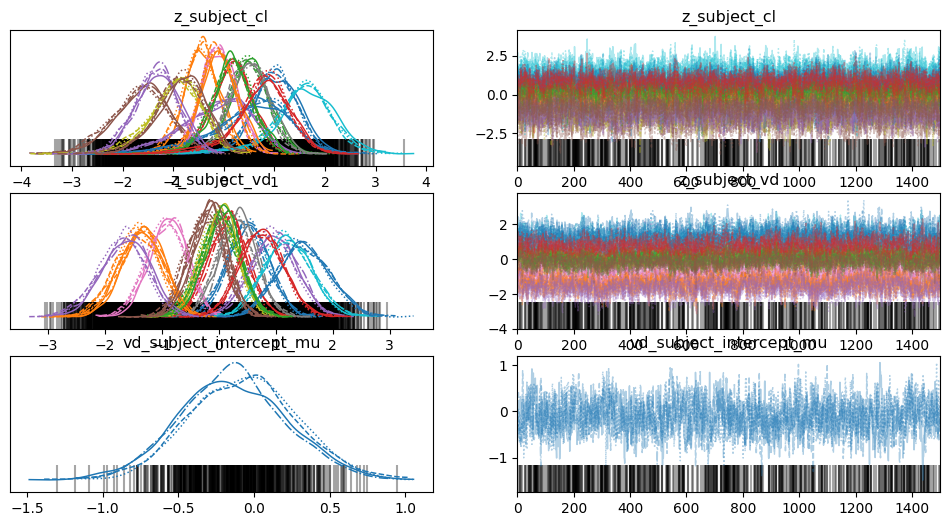

In [10]:
az.plot_trace(trace_NUTS, var_names = ['z_subject_cl', "z_subject_vd", 'vd_subject_intercept_mu'],)

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'ka_pop'}>,
        <Axes: title={'center': 'ka_pop'}>],
       [<Axes: title={'center': 'ka_subject_intercept_mu'}>,
        <Axes: title={'center': 'ka_subject_intercept_mu'}>],
       [<Axes: title={'center': 'z_subject_ka'}>,
        <Axes: title={'center': 'z_subject_ka'}>],
       [<Axes: title={'center': 'ka_Route_intercept_mu'}>,
        <Axes: title={'center': 'ka_Route_intercept_mu'}>],
       [<Axes: title={'center': 'z_Route_ka'}>,
        <Axes: title={'center': 'z_Route_ka'}>],
       [<Axes: title={'center': 'cl_pop'}>,
        <Axes: title={'center': 'cl_pop'}>],
       [<Axes: title={'center': 'cl_subject_intercept_mu'}>,
        <Axes: title={'center': 'cl_subject_intercept_mu'}>],
       [<Axes: title={'center': 'z_subject_cl'}>,
        <Axes: title={'center': 'z_subject_cl'}>],
       [<Axes: title={'center': 'vd_pop'}>,
        <Axes: title={'center': 'vd_pop'}>],
       [<Axes: title={'center': 'vd_subject_intercept_mu'}>,
        

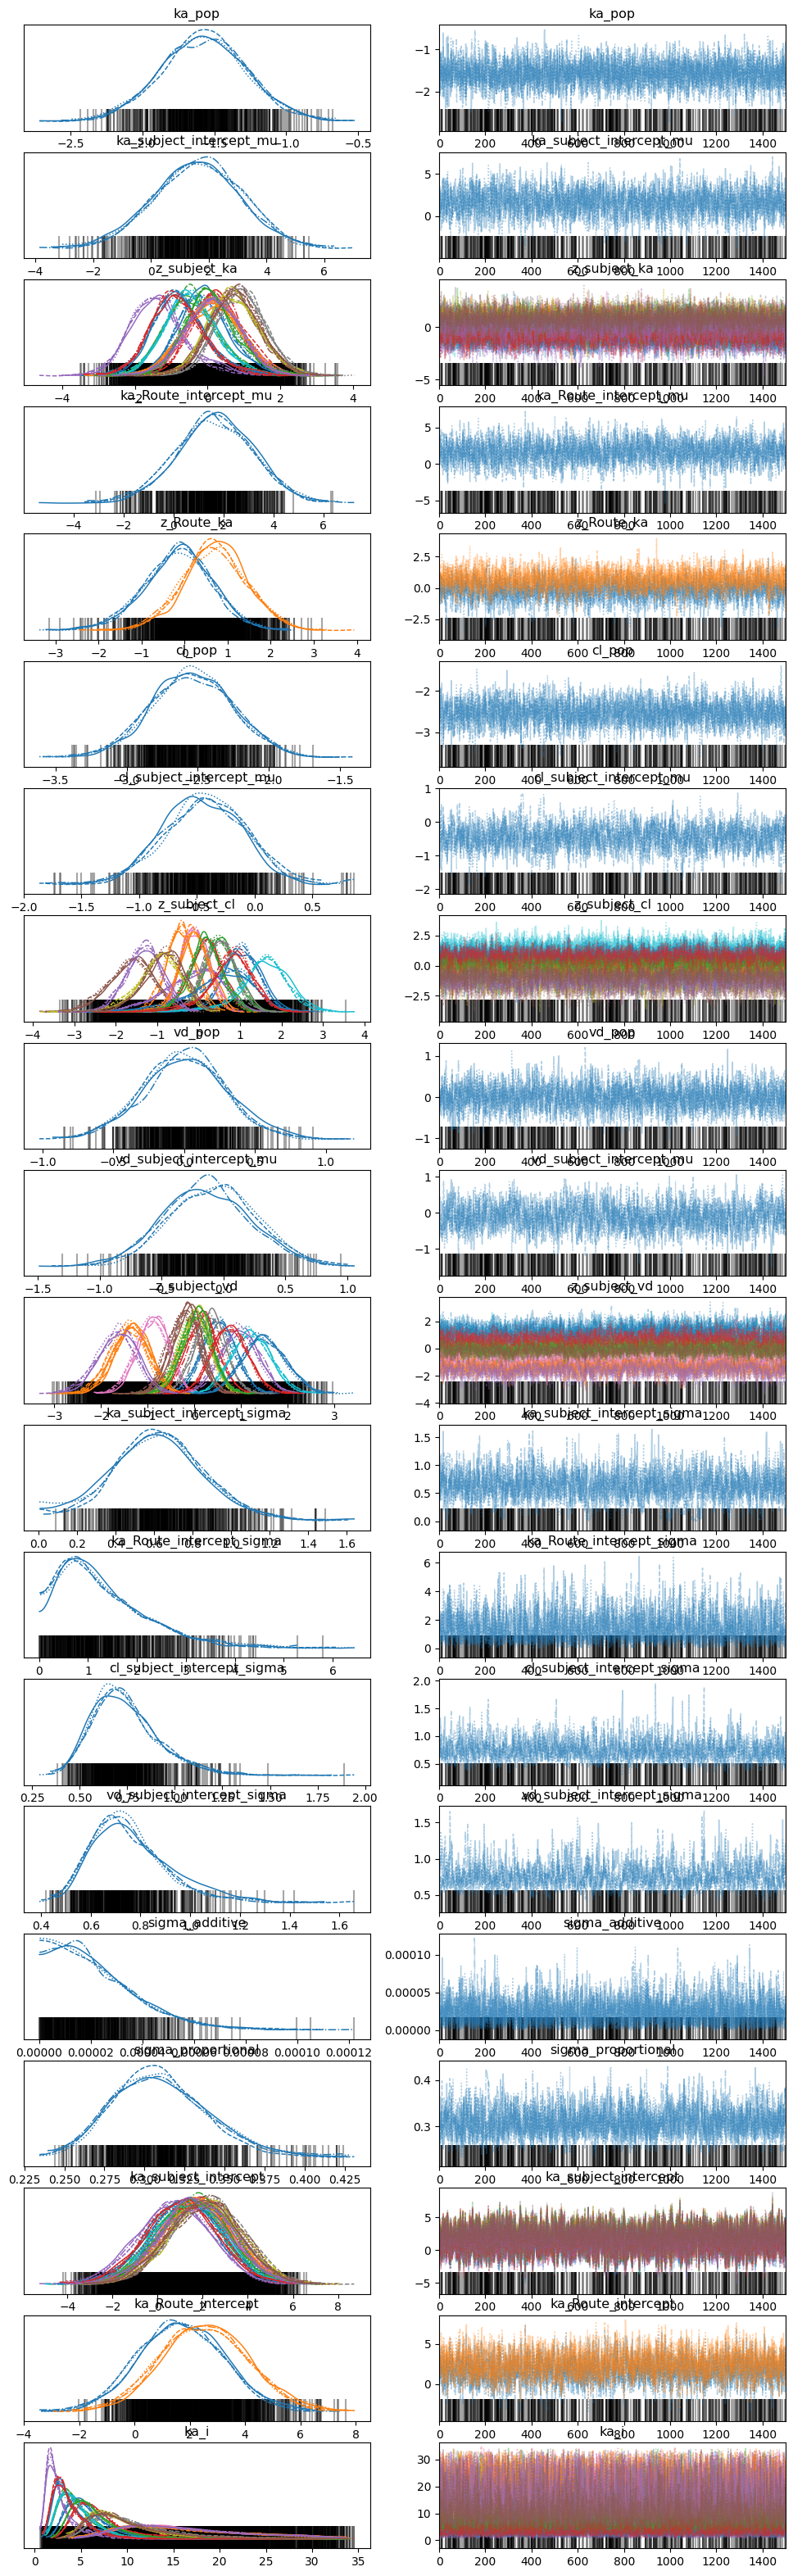

In [10]:
import arviz as az

az.plot_trace(trace_NUTS)

In [11]:
az.summary(trace_NUTS)

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ka_pop,-1.574,0.300,-2.179,-1.042,0.005,0.004,3963.0,3839.0,1.0
ka_subject_intercept_mu,1.618,1.523,-1.143,4.598,0.032,0.021,2259.0,3147.0,1.0
z_subject_ka[101.0],-0.079,0.735,-1.495,1.312,0.014,0.011,2745.0,2539.0,1.0
z_subject_ka[102.0],0.098,0.774,-1.296,1.576,0.014,0.010,2880.0,3626.0,1.0
z_subject_ka[103.0],-0.443,0.757,-1.848,0.971,0.015,0.013,2567.0,2651.0,1.0
...,...,...,...,...,...,...,...,...,...
sol[122],2842.374,409.631,2150.519,3606.134,5.974,6.855,5415.0,3966.0,1.0
sol[123],2643.651,353.241,2024.670,3288.906,5.077,6.292,5519.0,4023.0,1.0
sol[124],2367.149,287.064,1851.685,2884.678,3.929,4.975,5907.0,3825.0,1.0
sol[125],1904.597,240.647,1500.681,2364.601,3.381,3.702,5418.0,4467.0,1.0


['trace_multiple_hier.jb']

In [36]:
df_summ = pm.summary(trace_NUTS)

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venv

In [37]:
pred_df = df[['Subject','Conc', 'Time']].copy()

In [38]:
df_summ = df_summ.reset_index()
df_summ = df_summ.loc[df_summ['index'].str.contains('sol')]

In [39]:

pred_df['heirarch_IPRED'] = df_summ['mean'].to_numpy()
pred_df['heirarch_IPRED_ciLOWER'] = df_summ['hdi_3%'].to_numpy()
pred_df['heirarch_IPRED_ciUPPER'] = df_summ['hdi_97%'].to_numpy()

In [40]:
pred_df = pred_df.melt(id_vars = ['Subject', 'Time'], value_vars = ['Conc', 'heirarch_IPRED', 'heirarch_IPRED_ciLOWER', 'heirarch_IPRED_ciUPPER'])

In [41]:
import plotly.express as px

px.line(data_frame=pred_df, x = 'Time', y = 'value', animation_frame='Subject', color = 'variable')